# Using VAE for noise reduction

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets, transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchvision.utils import save_image

from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import os

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

data_root = '../../data'
if not os.path.exists(data_root):
    os.mkdir(data_root)

In [3]:
CUDA = use_cuda
SEED = 123
BATCH_SIZE = 128
LOG_INTERVAL = 25
EPOCHS_VAE = 20

ZDIMS = 128

## Load MNIST dataset

In [4]:
# DataLoader instances will load tensors directly into GPU memory
data_loader_args = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
# data_loader_args = {}


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_root, train=True, download=True,
                   transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=BATCH_SIZE, shuffle=True, **data_loader_args)

# Same for test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_root, train=False, 
                   transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=BATCH_SIZE, shuffle=True, **data_loader_args)

torch.Size([128, 1, 28, 28])
torch.Size([128])


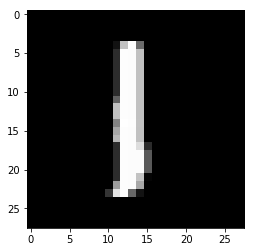

In [5]:
for el in train_loader:
    print(el[0].shape)
    print(el[1].shape)
    
    plt.imshow(el[0][0][0], cmap='gray')
    break

## Add noise for train_dataset

In [6]:
import numpy as np
import os
import cv2

def noisy(image, noise_typ):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

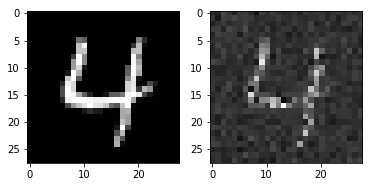

In [7]:
for el in train_loader:
    img = el[0][0].data.numpy()
    
    noisy_img = noisy(img, "speckle")
        
    f = plt.figure()

    f.add_subplot(1,2, 1)
    plt.imshow(img[0], cmap='gray')
    
    f.add_subplot(1,2, 2)
    plt.imshow(noisy_img[0], cmap='gray')
    
    plt.show(block=True)

    break

## Generate dataset with noise (X -> noise image, Y -> original image)

In [8]:
noise_data_train = []
noise_data_test = []

for batch in train_loader:    
    for i in range(len(batch[0])):
        orig_img = batch[0][i].data.numpy()
        
        noisy_img_speckle = noisy(orig_img, "speckle")
        noisy_img_gauss = noisy(orig_img, "gauss")
        
        noise_data_train.append([noisy_img_speckle, orig_img])
        noise_data_train.append([noisy_img_gauss, orig_img])
        
for batch in test_loader:    
    for i in range(len(batch[0])):
        orig_img = batch[0][i].data.numpy()
    
        noisy_img_speckle = noisy(orig_img, "speckle")
        noisy_img_gauss = noisy(orig_img, "gauss")

        noise_data_test.append([noisy_img_speckle, orig_img])
        noise_data_test.append([noisy_img_gauss, orig_img])
        
print("noise_data_train: ", len(noise_data_train))
print("noise_data_test: ", len(noise_data_test))

noise_data_train:  120000
noise_data_test:  20000


In [9]:
import torch.utils.data as utils

train_noise_dataloader = utils.DataLoader(noise_data_train, shuffle=True, batch_size=BATCH_SIZE)
test_noise_dataloader = utils.DataLoader(noise_data_test, shuffle=False, batch_size=BATCH_SIZE)

## Train VAE for noise reduction

In [10]:
from cnn_vae import VAE, loss_function

In [11]:
def trainVAE(epoch):
    noise_reduct_model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_noise_dataloader):    
        data = data.view(-1, 28, 28)
        data = Variable(data)
        
        if CUDA:
            data = data.cuda()
            
        data = data.float()
        optimizer.zero_grad()

        recon_batch, mu, logvar = noise_reduct_model(data)
        loss = loss_function(recon_batch, data, mu, logvar, BATCH_SIZE)
        loss.backward()
        
        train_loss += loss.data.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_noise_dataloader.dataset),
                100. * batch_idx / len(train_noise_dataloader),
                loss.data.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_noise_dataloader.dataset)))


In [12]:
def testVAE(epoch):
    noise_reduct_model.eval()
    test_loss = 0

    for i, (data, _) in enumerate(test_noise_dataloader):        
        if CUDA:
            data = data.cuda()
                
        data = data.float()

        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = noise_reduct_model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar, BATCH_SIZE).data.item()
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
            
            save_image(comparison.data.cpu(),
                     '../../results/DataAugMnist/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [13]:
noise_reduct_model = VAE(ZDIMS)
if CUDA:
    noise_reduct_model.cuda()

optimizer = optim.Adam(noise_reduct_model.parameters(), lr=1e-3)

In [14]:
for epoch in range(1, EPOCHS_VAE + 1):
    trainVAE(epoch)
    testVAE(epoch)

    torch.randn
    sample = Variable(torch.randn(64, ZDIMS))
    if CUDA:
        sample = sample.cuda()
    sample = noise_reduct_model.decode(sample).cpu()

    # save out as an 8x8 matrix EPOCHS_VAEof MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    save_image(sample.data.view(64, 1, 28, 28),
               '../../results/NoiseReductMnist/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/120000 (0%)]	Loss: 0.005588
Train Epoch: 1 [3200/120000 (3%)]	Loss: -0.071703
Train Epoch: 1 [6400/120000 (5%)]	Loss: -0.075088
Train Epoch: 1 [9600/120000 (8%)]	Loss: -0.090425
Train Epoch: 1 [12800/120000 (11%)]	Loss: -0.106034
Train Epoch: 1 [16000/120000 (13%)]	Loss: -0.107455
Train Epoch: 1 [19200/120000 (16%)]	Loss: -0.118420
Train Epoch: 1 [22400/120000 (19%)]	Loss: -0.130970
Train Epoch: 1 [25600/120000 (21%)]	Loss: -0.132198
Train Epoch: 1 [28800/120000 (24%)]	Loss: -0.132160
Train Epoch: 1 [32000/120000 (27%)]	Loss: -0.139325
Train Epoch: 1 [35200/120000 (29%)]	Loss: -0.135820
Train Epoch: 1 [38400/120000 (32%)]	Loss: -0.133685
Train Epoch: 1 [41600/120000 (35%)]	Loss: -0.133303
Train Epoch: 1 [44800/120000 (37%)]	Loss: -0.126073
Train Epoch: 1 [48000/120000 (40%)]	Loss: -0.133378
Train Epoch: 1 [51200/120000 (43%)]	Loss: -0.128192
Train Epoch: 1 [54400/120000 (45%)]	Loss: -0.128221
Train Epoch: 1 [57600/120000 (48%)]	Loss: -0.125087
Train Epoch: 1 [60800/12

/home/andrew/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


====> Test set loss: -0.2523
Train Epoch: 2 [0/120000 (0%)]	Loss: -0.129398
Train Epoch: 2 [3200/120000 (3%)]	Loss: -0.134304
Train Epoch: 2 [6400/120000 (5%)]	Loss: -0.127400
Train Epoch: 2 [9600/120000 (8%)]	Loss: -0.131315
Train Epoch: 2 [12800/120000 (11%)]	Loss: -0.123319
Train Epoch: 2 [16000/120000 (13%)]	Loss: -0.127721
Train Epoch: 2 [19200/120000 (16%)]	Loss: -0.126519
Train Epoch: 2 [22400/120000 (19%)]	Loss: -0.124596
Train Epoch: 2 [25600/120000 (21%)]	Loss: -0.131807
Train Epoch: 2 [28800/120000 (24%)]	Loss: -0.124466
Train Epoch: 2 [32000/120000 (27%)]	Loss: -0.122825
Train Epoch: 2 [35200/120000 (29%)]	Loss: -0.126853
Train Epoch: 2 [38400/120000 (32%)]	Loss: -0.126252
Train Epoch: 2 [41600/120000 (35%)]	Loss: -0.125911
Train Epoch: 2 [44800/120000 (37%)]	Loss: -0.127338
Train Epoch: 2 [48000/120000 (40%)]	Loss: -0.127223
Train Epoch: 2 [51200/120000 (43%)]	Loss: -0.124083
Train Epoch: 2 [54400/120000 (45%)]	Loss: -0.123074
Train Epoch: 2 [57600/120000 (48%)]	Loss: -0.1

Train Epoch: 6 [6400/120000 (5%)]	Loss: -0.129397
Train Epoch: 6 [9600/120000 (8%)]	Loss: -0.130048
Train Epoch: 6 [12800/120000 (11%)]	Loss: -0.124798
Train Epoch: 6 [16000/120000 (13%)]	Loss: -0.123815
Train Epoch: 6 [19200/120000 (16%)]	Loss: -0.127679
Train Epoch: 6 [22400/120000 (19%)]	Loss: -0.124296
Train Epoch: 6 [25600/120000 (21%)]	Loss: -0.127182
Train Epoch: 6 [28800/120000 (24%)]	Loss: -0.122390
Train Epoch: 6 [32000/120000 (27%)]	Loss: -0.128920
Train Epoch: 6 [35200/120000 (29%)]	Loss: -0.126442
Train Epoch: 6 [38400/120000 (32%)]	Loss: -0.125932
Train Epoch: 6 [41600/120000 (35%)]	Loss: -0.126875
Train Epoch: 6 [44800/120000 (37%)]	Loss: -0.120532
Train Epoch: 6 [48000/120000 (40%)]	Loss: -0.123985
Train Epoch: 6 [51200/120000 (43%)]	Loss: -0.122688
Train Epoch: 6 [54400/120000 (45%)]	Loss: -0.129903
Train Epoch: 6 [57600/120000 (48%)]	Loss: -0.127703
Train Epoch: 6 [60800/120000 (51%)]	Loss: -0.125325
Train Epoch: 6 [64000/120000 (53%)]	Loss: -0.126018
Train Epoch: 6 [

Train Epoch: 10 [12800/120000 (11%)]	Loss: -0.125707
Train Epoch: 10 [16000/120000 (13%)]	Loss: -0.123743
Train Epoch: 10 [19200/120000 (16%)]	Loss: -0.129124
Train Epoch: 10 [22400/120000 (19%)]	Loss: -0.128416
Train Epoch: 10 [25600/120000 (21%)]	Loss: -0.129873
Train Epoch: 10 [28800/120000 (24%)]	Loss: -0.126832
Train Epoch: 10 [32000/120000 (27%)]	Loss: -0.126622
Train Epoch: 10 [35200/120000 (29%)]	Loss: -0.129861
Train Epoch: 10 [38400/120000 (32%)]	Loss: -0.128420
Train Epoch: 10 [41600/120000 (35%)]	Loss: -0.129318
Train Epoch: 10 [44800/120000 (37%)]	Loss: -0.123548
Train Epoch: 10 [48000/120000 (40%)]	Loss: -0.127936
Train Epoch: 10 [51200/120000 (43%)]	Loss: -0.127683
Train Epoch: 10 [54400/120000 (45%)]	Loss: -0.124957
Train Epoch: 10 [57600/120000 (48%)]	Loss: -0.125334
Train Epoch: 10 [60800/120000 (51%)]	Loss: -0.126572
Train Epoch: 10 [64000/120000 (53%)]	Loss: -0.123837
Train Epoch: 10 [67200/120000 (56%)]	Loss: -0.129035
Train Epoch: 10 [70400/120000 (59%)]	Loss: -0.

Train Epoch: 14 [6400/120000 (5%)]	Loss: -0.132350
Train Epoch: 14 [9600/120000 (8%)]	Loss: -0.130594
Train Epoch: 14 [12800/120000 (11%)]	Loss: -0.126663
Train Epoch: 14 [16000/120000 (13%)]	Loss: -0.126870
Train Epoch: 14 [19200/120000 (16%)]	Loss: -0.126574
Train Epoch: 14 [22400/120000 (19%)]	Loss: -0.127540
Train Epoch: 14 [25600/120000 (21%)]	Loss: -0.128555
Train Epoch: 14 [28800/120000 (24%)]	Loss: -0.133120
Train Epoch: 14 [32000/120000 (27%)]	Loss: -0.126573
Train Epoch: 14 [35200/120000 (29%)]	Loss: -0.129192
Train Epoch: 14 [38400/120000 (32%)]	Loss: -0.124487
Train Epoch: 14 [41600/120000 (35%)]	Loss: -0.128383
Train Epoch: 14 [44800/120000 (37%)]	Loss: -0.127840
Train Epoch: 14 [48000/120000 (40%)]	Loss: -0.136532
Train Epoch: 14 [51200/120000 (43%)]	Loss: -0.125769
Train Epoch: 14 [54400/120000 (45%)]	Loss: -0.123872
Train Epoch: 14 [57600/120000 (48%)]	Loss: -0.124973
Train Epoch: 14 [60800/120000 (51%)]	Loss: -0.129590
Train Epoch: 14 [64000/120000 (53%)]	Loss: -0.1326

Train Epoch: 18 [6400/120000 (5%)]	Loss: -0.126535
Train Epoch: 18 [9600/120000 (8%)]	Loss: -0.135393
Train Epoch: 18 [12800/120000 (11%)]	Loss: -0.128593
Train Epoch: 18 [16000/120000 (13%)]	Loss: -0.129923
Train Epoch: 18 [19200/120000 (16%)]	Loss: -0.133411
Train Epoch: 18 [22400/120000 (19%)]	Loss: -0.126438
Train Epoch: 18 [25600/120000 (21%)]	Loss: -0.128859
Train Epoch: 18 [28800/120000 (24%)]	Loss: -0.124082
Train Epoch: 18 [32000/120000 (27%)]	Loss: -0.123379
Train Epoch: 18 [35200/120000 (29%)]	Loss: -0.130956
Train Epoch: 18 [38400/120000 (32%)]	Loss: -0.128057
Train Epoch: 18 [41600/120000 (35%)]	Loss: -0.126549
Train Epoch: 18 [44800/120000 (37%)]	Loss: -0.131824
Train Epoch: 18 [48000/120000 (40%)]	Loss: -0.126554
Train Epoch: 18 [51200/120000 (43%)]	Loss: -0.126553
Train Epoch: 18 [54400/120000 (45%)]	Loss: -0.129523
Train Epoch: 18 [57600/120000 (48%)]	Loss: -0.128087
Train Epoch: 18 [60800/120000 (51%)]	Loss: -0.130909
Train Epoch: 18 [64000/120000 (53%)]	Loss: -0.1247

# Test noise reduction model

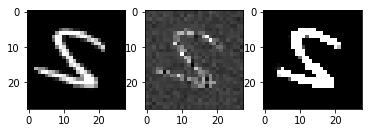

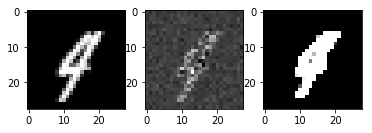

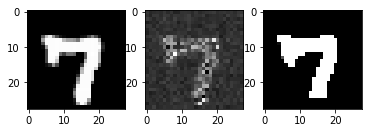

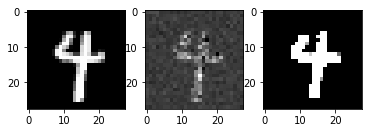

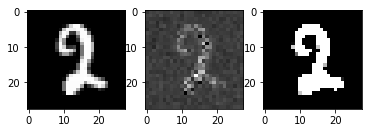

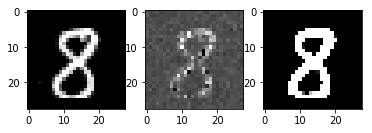

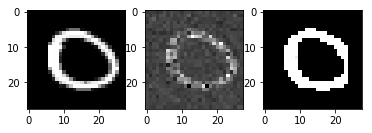

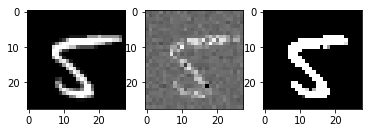

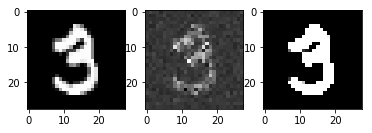

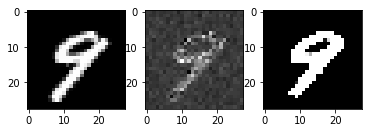

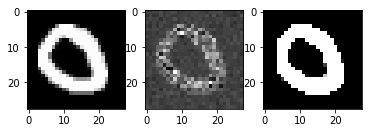

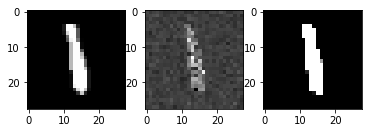

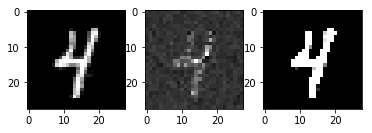

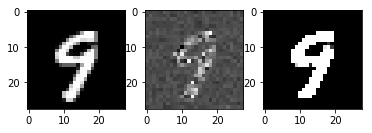

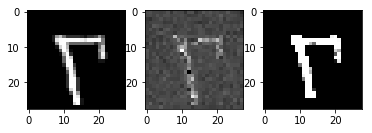

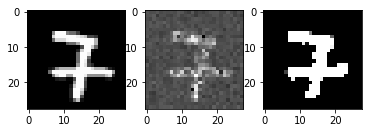

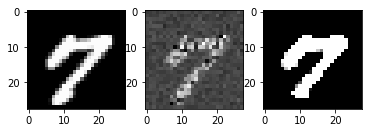

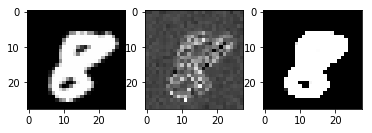

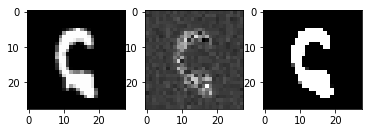

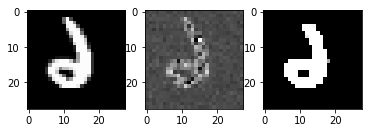

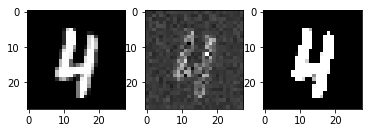

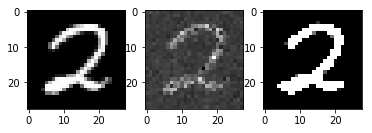

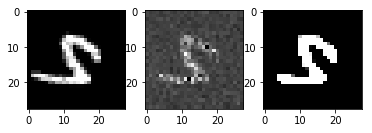

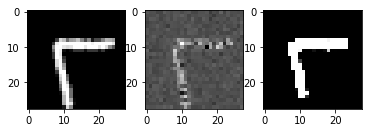

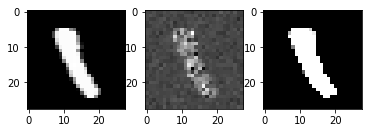

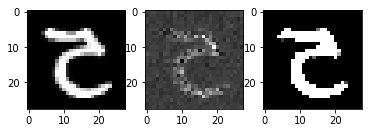

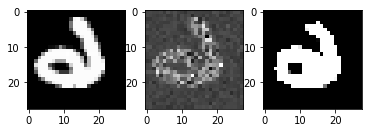

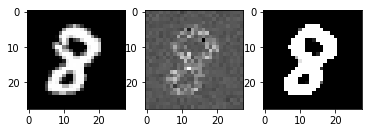

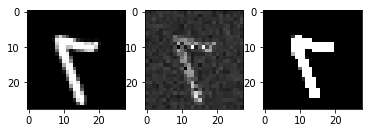

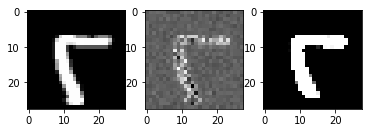

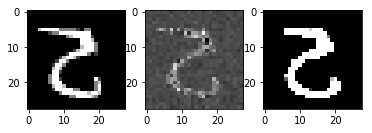

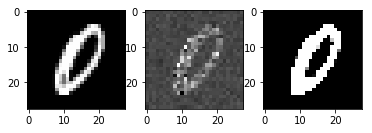

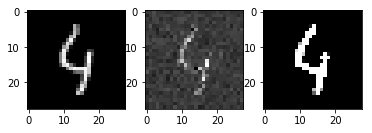

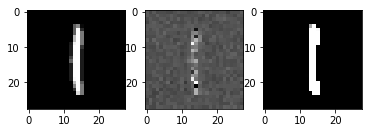

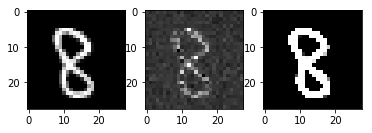

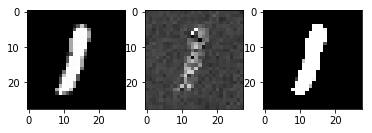

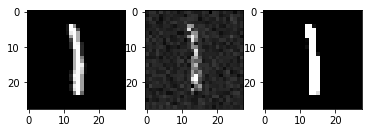

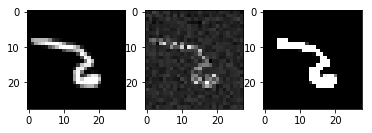

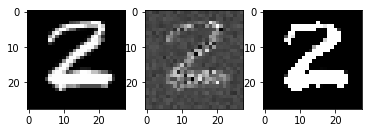

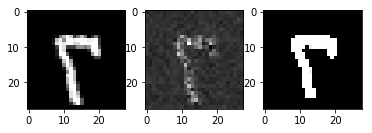

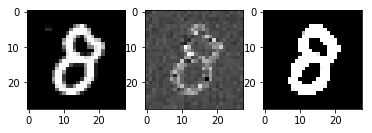

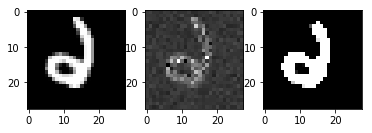

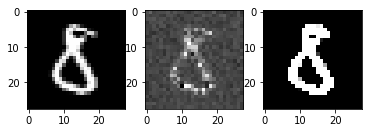

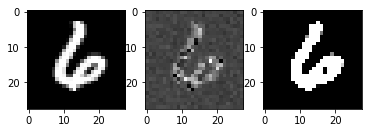

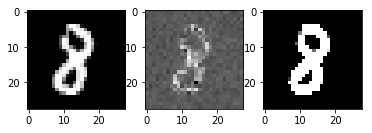

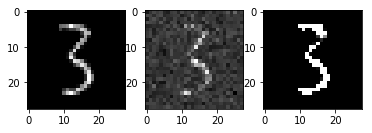

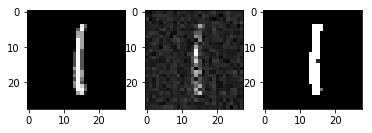

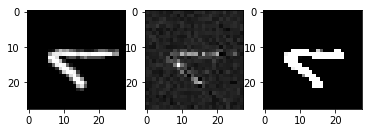

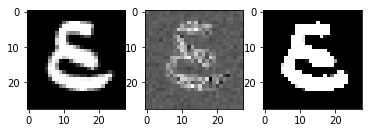

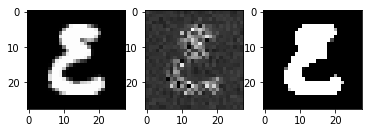

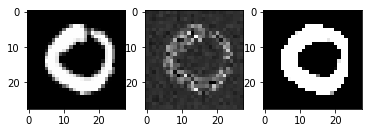

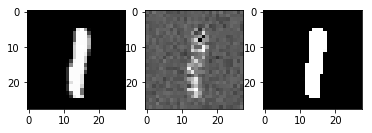

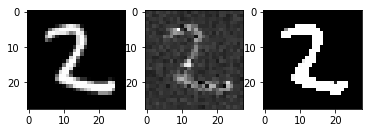

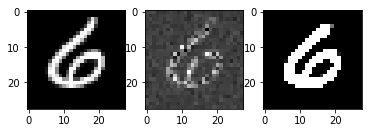

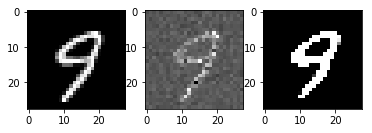

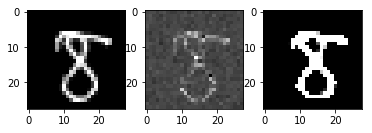

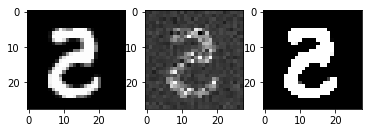

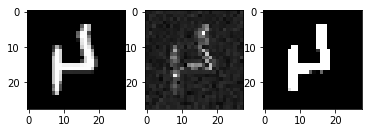

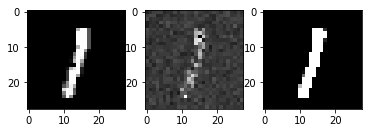

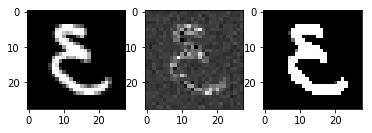

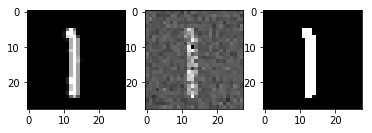

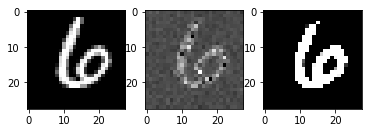

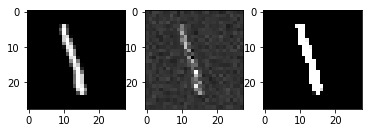

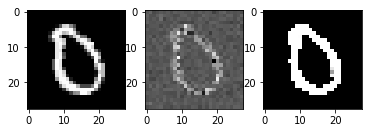

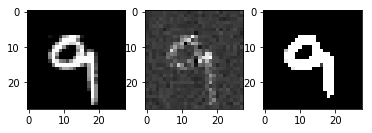

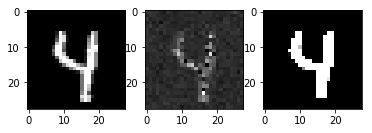

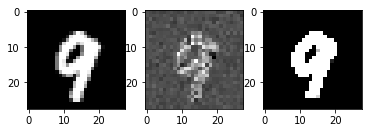

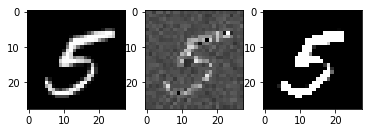

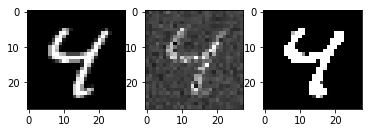

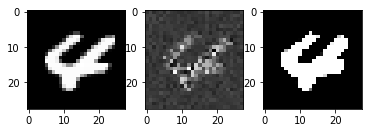

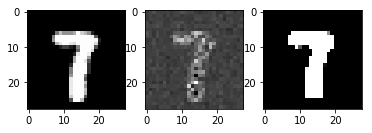

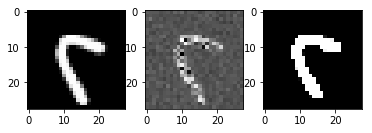

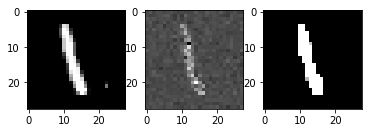

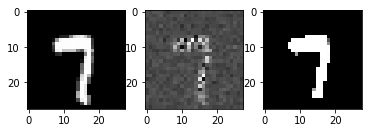

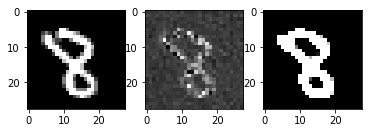

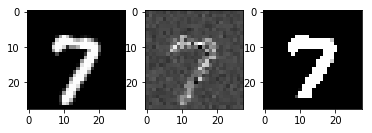

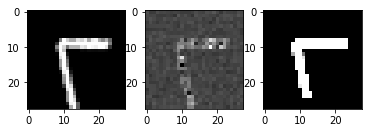

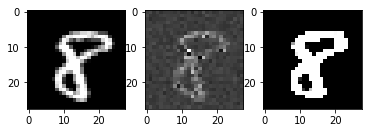

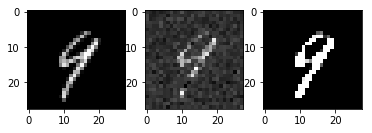

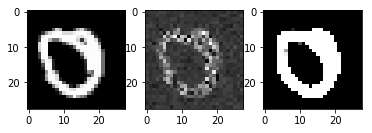

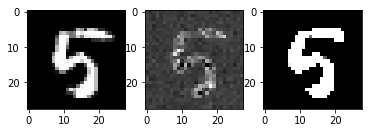

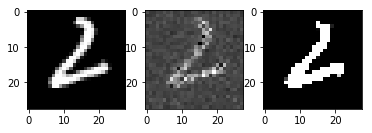

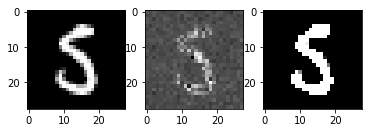

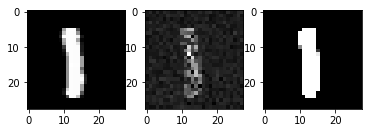

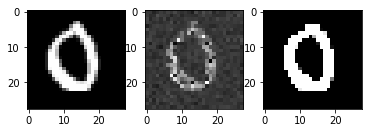

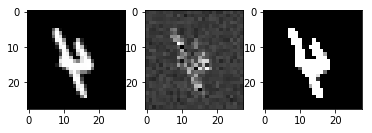

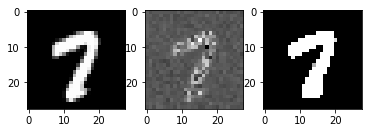

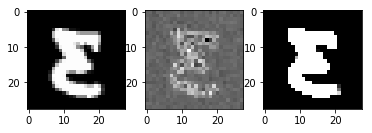

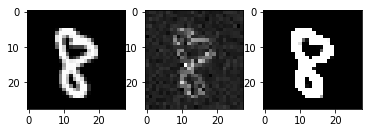

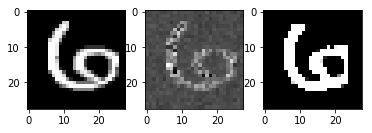

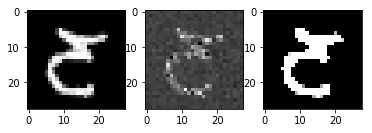

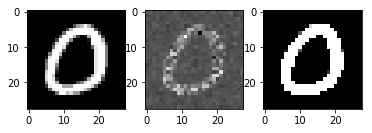

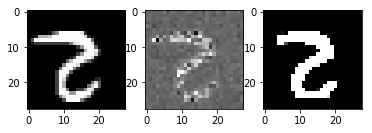

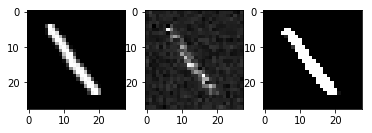

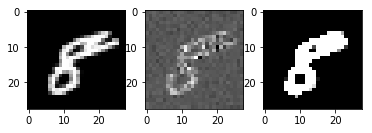

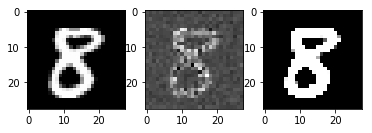

In [ ]:
for batch in test_noise_dataloader:
    real_img = batch[1][0][0]
    noise_img = batch[0][0][0]
    
    denoised_img = noise_reduct_model(real_img.cuda()) # returns img, mu, logvar
    
    denoised_img = denoised_img[0].view(28, 28)
    denoised_img = denoised_img.detach().cpu().numpy()
    
    f = plt.figure()

    f.add_subplot(1, 3, 1)
    plt.imshow(real_img, cmap='gray')
    
    f.add_subplot(1, 3, 2)
    plt.imshow(noise_img, cmap='gray')
    
    f.add_subplot(1, 3, 3)
    plt.imshow(denoised_img, cmap='gray')

    
    plt.show(block=True)